# Data Understanding

In [1]:
# install kaggle
import requests
URL = "https://raw.githubusercontent.com/rezaafaisal/source/main/kaggle.json"
response = requests.get(URL)
open("kaggle.json", "wb").write(response.content)

!ls -lha kaggle.json
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

-rw-r--r-- 1 root root 68 Sep 28 15:02 kaggle.json


In [2]:
# unduh dataset
!kaggle datasets download -d lorentzyeung/imdb-video-games-dataset

  0% 0.00/1.32M [00:00<?, ?B/s]
100% 1.32M/1.32M [00:00<00:00, 104MB/s]


In [3]:
# import library yang digunakan
import shutil
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import  OneHotEncoder
from sklearn.metrics.pairwise import cosine_similarity
from tabulate import tabulate

In [4]:
# extrak dataset
shutil.unpack_archive('/content/imdb-video-games-dataset.zip', 'dataset')

In [5]:
# load dataset
games_df = pd.read_csv('/content/dataset/imdb_video_games.csv')

In [6]:
# jumlah data
row_len, col_len = games_df.shape
print(f"Jumlah baris : {row_len}\nJumlah Kolom : {col_len}")

Jumlah baris : 14682
Jumlah Kolom : 11


In [7]:
games_df.head()

,Popularity,Title,Genre,User Rating,Number of Votes,Runtime,Year,Summary,Director,Stars,Certificate
0,0,Baldur's Gate III,"Action, Adventure, Fantasy",9.8,"1,130",NaN,2023.0,Return to the Faerun in a tale of fellowship a...,"Swen Vincke,","Amelia Tyler, Neil Newbon, Jennifer English, D...",M
1,1,Starfield,"Action, Adventure, Drama",8.7,524,NaN,2023.0,"Set 300 years in the future, the player will a...","Todd Howard,","Sumalee Montano, Damien C. Haas, Barry Wiggins...",M
2,2,Red Dead Redemption II,"Action, Adventure, Crime",9.7,"47,844",NaN,2018.0,Amidst the decline of the Wild West at the tur...,NaN,"Benjamin Byron Davis, Roger Clark, Rob Wiethof...",M
3,3,Armored Core VI: Fires of Rubicon,"Action, Adventure, Sci-Fi",7.9,114,NaN,2023.0,Fifty years after a cataclysm caused by a subs...,"Masaru Yamamura, Kenneth Kin Yue Chan, Hidetak...","Fairouz Ai, Takayuki Sakazume, Megumi Han, Aya...",T
4,4,The Quarry,"Action, Adventure, Drama",8.0,"4,625",NaN,2022.0,When the sun goes down on the last night of su...,"Will Byles,","Siobhan Williams, Skyler Gisondo, Ted Raimi, G...",M


# Exploratory Data Analysis

In [8]:
games_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14682 entries, 0 to 14681
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Popularity       14682 non-null  int64  
 1   Title            14682 non-null  object 
 2   Genre            14682 non-null  object 
 3   User Rating      8654 non-null   float64
 4   Number of Votes  8654 non-null   object 
 5   Runtime          101 non-null    object 
 6   Year             14463 non-null  float64
 7   Summary          8480 non-null   object 
 8   Director         3967 non-null   object 
 9   Stars            8617 non-null   object 
 10  Certificate      6704 non-null   object 
dtypes: float64(2), int64(1), object(8)
memory usage: 1.2+ MB


In [9]:
games_df.describe()

,Popularity,User Rating,Year
count,14682.000000,8654.000000,14463.000000
mean,7340.500000,6.888375,2005.195188
std,4238.472661,1.215583,12.031133
min,0.000000,1.300000,1952.000000
25%,3670.250000,6.200000,1996.000000
50%,7340.500000,7.100000,2007.000000
75%,11010.750000,7.700000,2016.000000
max,14681.000000,9.800000,2030.000000


In [10]:
# cek fitur genre
print(f"Jumlah genre kombinasi unik : {games_df['Genre'].nunique()}")

Jumlah genre kombinasi unik : 156


Jumlah genre game:  34


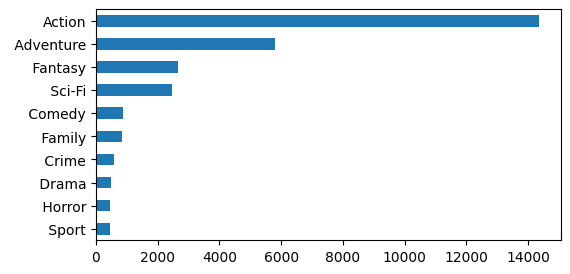

In [11]:
genres = games_df['Genre'].str.split(',').explode()

print('Jumlah genre game: ', len(genres.unique()))

plt.figure(figsize=(6,3))
genres.value_counts(ascending=True)[-10:].plot(kind='barh')
plt.show()

Genre                         Count    Percent
--------------------------  -------  ---------
Action                         4971   33.8578
Action, Adventure               740    5.04019
Action, Adventure, Comedy       632    4.30459
Action, Adventure, Drama        297    2.02289
Action, Adventure, Family       532    3.62348
Action, Adventure, Fantasy     1865   12.7026
Action, Adventure, Sci-Fi       714    4.8631
Action, Fantasy                 377    2.56777
Action, Sci-Fi                 1233    8.39804
Action, Sport                   260    1.77088


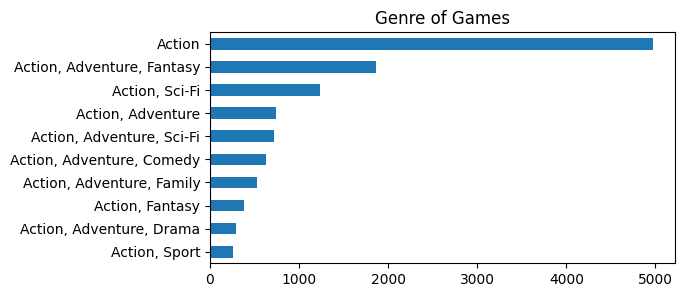

In [12]:
# mengecek 10 genre paling banyak dan paling sedikit
genre_count = games_df['Genre'].value_counts(ascending=True)[-10:]
percent = 100*games_df['Genre'].value_counts(normalize=True)

print(tabulate(
    pd.DataFrame({
        'count' : genre_count[:10],
        'percent': percent[:10]
    }),
    headers=['Genre', 'Count', 'Percent']))

plt.figure(figsize=(6,3))
genre_count.plot(kind='barh', title='Genre of Games')
plt.show()

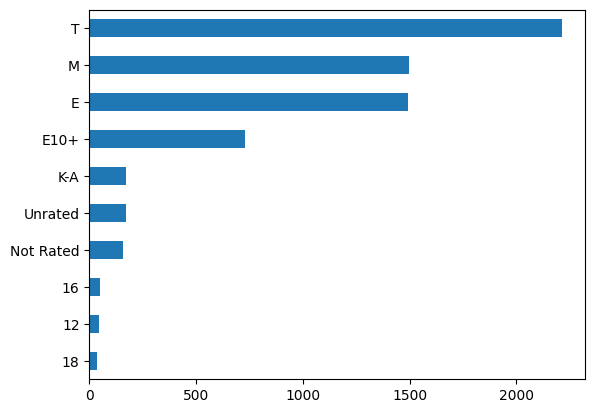

In [58]:
# mengecek fitur Certificate

certificate_count = games_df['Certificate'].value_counts(ascending=True)[-10:]

certificate_count.plot(kind='barh')
plt.show()

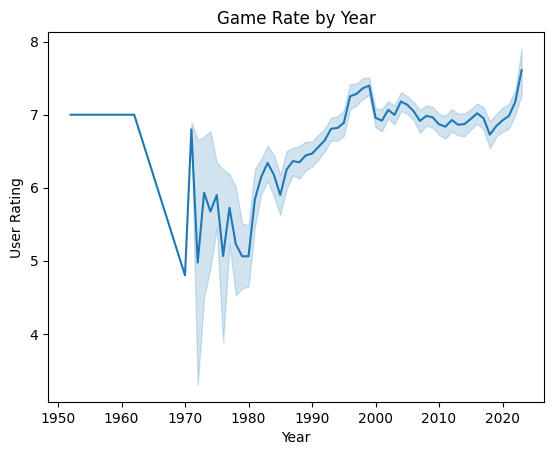

In [65]:
sns.lineplot(data=games_df, x='Year', y='User Rating')
plt.title('Game Rate by Year')
plt.show()

# Data Preprocessing

In [13]:
def slugify(text):
  return text.replace(' ', '_').lower()

In [14]:
# mengambil fitur yang akan digunakan
features = ['Title', 'Genre', 'User Rating', 'Number of Votes', 'Year']

new_df = pd.DataFrame()

for feature in features:
  new_df[slugify(feature)] = games_df[feature]

In [15]:
new_df.head()

,title,genre,user_rating,number_of_votes,year
0,Baldur's Gate III,"Action, Adventure, Fantasy",9.8,"1,130",2023.0
1,Starfield,"Action, Adventure, Drama",8.7,524,2023.0
2,Red Dead Redemption II,"Action, Adventure, Crime",9.7,"47,844",2018.0
3,Armored Core VI: Fires of Rubicon,"Action, Adventure, Sci-Fi",7.9,114,2023.0
4,The Quarry,"Action, Adventure, Drama",8.0,"4,625",2022.0


In [16]:
new_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14682 entries, 0 to 14681
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   title            14682 non-null  object 
 1   genre            14682 non-null  object 
 2   user_rating      8654 non-null   float64
 3   number_of_votes  8654 non-null   object 
 4   year             14463 non-null  float64
dtypes: float64(2), object(3)
memory usage: 573.6+ KB


In [17]:
# cek missing value
new_df.isna().sum()

title                 0
genre                 0
user_rating        6028
number_of_votes    6028
year                219
dtype: int64

In [18]:
# cek duplicate
new_df.duplicated().sum()

7

In [19]:
# menghapus missing value
game_clean_df = new_df.dropna()

# menghapus data duplicate
game_clean_df = game_clean_df.drop_duplicates()

In [20]:
# cek mising value dan duplikat
print(f"Jumlah missing value : \n{game_clean_df.isna().sum()}")
print(f"Jumlah duplikat : {game_clean_df.duplicated().sum()}")

Jumlah missing value : 
title              0
genre              0
user_rating        0
number_of_votes    0
year               0
dtype: int64
Jumlah duplikat : 0


In [21]:
# ubah tipe data number_of_votes ke integer
game_clean_df['number_of_votes'] = game_clean_df['number_of_votes'].str.replace(',', '').astype(int)

In [22]:
game_clean_df['number_of_votes'].sample(5)

1010    2293
9336      20
3553     125
9049      12
8086      15
Name: number_of_votes, dtype: int64

In [23]:
# cek dataframe
game_clean_df.head()

,title,genre,user_rating,number_of_votes,year
0,Baldur's Gate III,"Action, Adventure, Fantasy",9.8,1130,2023.0
1,Starfield,"Action, Adventure, Drama",8.7,524,2023.0
2,Red Dead Redemption II,"Action, Adventure, Crime",9.7,47844,2018.0
3,Armored Core VI: Fires of Rubicon,"Action, Adventure, Sci-Fi",7.9,114,2023.0
4,The Quarry,"Action, Adventure, Drama",8.0,4625,2022.0


# Data Preparation

In [24]:
# mengecek jumlah game
print(f"Jumlah game dengan nama unik : {game_clean_df.title.nunique()}")

Jumlah game dengan nama unik : 8418


In [25]:
# mengecek jumlah genre yang memiliki kombinasi unik
print(f"Jumlah genre dengan kombinasi unik : {game_clean_df.genre.nunique()}")

Jumlah genre dengan kombinasi unik : 136


In [26]:
# menambahkan kolom sesuai nama genre
game_clean_df['genre'] = game_clean_df['genre'].str.split(',')

for index, data in game_clean_df.iterrows():
  for genre in data['genre']:
    game_clean_df.at[index, genre.lower()] = 1

game_clean_df = game_clean_df.fillna(0)

game_clean_df.head()

,title,genre,user_rating,number_of_votes,year,action,adventure,fantasy,drama,crime,...,western,short,comedy,family,horror,fantasy,adventure,music,sci-fi,musical
0,Baldur's Gate III,"[Action, Adventure, Fantasy]",9.8,1130,2023.0,1.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Starfield,"[Action, Adventure, Drama]",8.7,524,2023.0,1.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Red Dead Redemption II,"[Action, Adventure, Crime]",9.7,47844,2018.0,1.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Armored Core VI: Fires of Rubicon,"[Action, Adventure, Sci-Fi]",7.9,114,2023.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,The Quarry,"[Action, Adventure, Drama]",8.0,4625,2022.0,1.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [27]:
# mengambil matriks genre
genre_matrix = game_clean_df.loc[:, 'action':]
genre_matrix.sample(5)

,action,adventure,fantasy,drama,crime,sci-fi,mystery,horror,thriller,comedy,...,western,short,comedy,family,horror,fantasy,adventure,music,sci-fi,musical
6112,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6198,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13934,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
928,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1822,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Model Development

In [28]:
data = game_clean_df

In [29]:
# hitung cosine similarity pada matrix genre
cosine_sim = cosine_similarity(genre_matrix)
print(cosine_sim)

[[1.         0.66666667 0.66666667 ... 0.81649658 0.81649658 0.40824829]
 [0.66666667 1.         0.66666667 ... 0.40824829 0.81649658 0.40824829]
 [0.66666667 0.66666667 1.         ... 0.40824829 0.81649658 0.40824829]
 ...
 [0.81649658 0.40824829 0.40824829 ... 1.         0.5        0.5       ]
 [0.81649658 0.81649658 0.81649658 ... 0.5        1.         0.5       ]
 [0.40824829 0.40824829 0.40824829 ... 0.5        0.5        1.        ]]


In [30]:
# membuat dataframe dari varible cosine similarity dengan baris dan kolom berupa nama game
cosine_sim_df = pd.DataFrame(cosine_sim, index=data['title'], columns=data['title'])

print(cosine_sim_df.shape)

(8651, 8651)


In [31]:
# melihat similarity matrik
cosine_sim_df.sample(5, axis=1).sample(10, axis=0)

title,Interstate '76 Arsenal,Star Wars Arcade,Whiplash,Dark Earth,Sniper Elite V2
title,,,,,
Final Fight,0.577350,0.408248,0.666667,0.333333,0.333333
Star Trek: Armada,0.577350,0.816497,0.666667,0.666667,0.333333
Mario Kart Wii,0.577350,0.408248,0.333333,0.666667,0.333333
N.O.V.A. Near Orbit Vanguard Alliance,0.707107,1.000000,0.408248,0.816497,0.408248
Lunar: Eternal Blue,0.577350,0.408248,1.000000,0.333333,0.333333
Gundam Evolution,1.000000,0.707107,0.577350,0.577350,0.577350
The Last Stand: Union City,0.577350,0.408248,0.666667,0.333333,0.333333
Blood Wake,0.577350,0.408248,0.333333,0.666667,0.333333
Sunset Overdrive,0.577350,0.408248,1.000000,0.333333,0.333333


In [66]:
# fungsi mencetak rekomendasi
def display_recommendation(by, data, k):
  data = data.loc[:, :'year']
  columns = data.columns
  closest = data.sort_values(by=by, ascending=False).head(k)
  print(f"Reccomendation by {by}")
  print(tabulate(closest.set_index('title'), headers=columns))
  print("\n")


# membuat fungsi mendapatkan rekomendasi
def game_recommendations(name, similarity_data=cosine_sim_df, items=data, k=5):
  # Mengambil data dengan menggunakan argpartition untuk melakukan partisi secara tidak langsung sepanjang sumbu yang diberikan
  # Dataframe diubah menjadi numpy
  # Range(start, stop, step)
  index = similarity_data.loc[:, name].to_numpy().argpartition(range(-1, -k, -1))

  # Mengambil 50 data dengan similarity terbesar dari index yang ada
  closest = similarity_data.iloc[index[-1:-(50):-1]][name]

  # Drop nama_resto agar nama resto yang dicari tidak muncul dalam daftar rekomendasi
  closest = closest.drop(name, errors='ignore')

  # buat df baru untuk mengurutkan berdasrkan (genre, rating), (genre, tahun terbaru), (genre, jumlah pemain / jumlah vote)
  closest_df = pd.DataFrame(closest).merge(data, on='title').rename({name: 'cosine_similarity'}, axis=1)

  display_recommendation('user_rating', closest_df, k)
  display_recommendation('number_of_votes', closest_df, k)
  display_recommendation('year', closest_df, k)

In [33]:
# list nama game untuk meminta rekomendasi
game_clean_df[['title', 'genre']].sample(10)

,title,genre
7700,The Powerpuff Girls: Bad Mojo Jojo,[Action]
4753,Atom RPG,"[Action, Adventure, Sci-Fi]"
468,Demon Slayer: The Hinokami Chronicles,"[Action, Adventure, Fantasy]"
129,Borderlands 3,"[Action, Adventure, Comedy]"
13586,Asteroids Hyper 64,"[Action, Sci-Fi]"
2413,Serious Sam II,"[Action, Adventure, Comedy]"
6754,Pac-Man Party,[Action]
7769,Samael: The Legacy of Ophiuchus,"[Action, Adventure]"
5693,Drakensang: The Dark Eye,"[Action, Adventure, Fantasy]"
5892,Red Alarm,[Action]


In [67]:
# mendapatkan rekomendasi game
game_recommendations('Chiller') # genre : actian, horror

Reccomendation by user_rating
title                                 cosine_similarity  genre                              user_rating    number_of_votes    year
----------------------------------  -------------------  -------------------------------  -------------  -----------------  ------
Parasite Eve                                   0.816497  ['Action', ' Drama', ' Horror']            8.5                687    1998
Fright Night                                   1         ['Action', ' Horror']                      8.3                 30    1988
Terrordrome: Rise of the Boogeymen             1         ['Action', ' Horror']                      8.3                 30    2015
Left 4 Dead                                    1         ['Action', ' Horror']                      8.3               6375    2008
Left 4 Dead 2                                  1         ['Action', ' Horror']                      8.3               7334    2009


Reccomendation by number_of_votes
title            